In [1]:
import os
os.chdir('..')

In [2]:
import pysindy as ps
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import root_mean_squared_error

import Yukawa_SINDy as ys
import cross_validation as cv

# import scaling constant from working directory and declare as global variable
from pickle import load
with open('scaling_const.float','rb') as f:
    SCALING_CONST = load(f)

from importlib import reload
from copy import copy

In [3]:
reload(cv)
reload(ys)

<module 'Yukawa_SINDy' from '/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py'>

# Random effects of weak SINDy

Weak SINDy chooses a random sampling of subdomains every time such a model is fit. Here, we will investigate how the number of those subdomains affects the quality of the output by looking at the predictive error and the "true error", or "coefficient error". The predictive error is simply how well the SINDy prediction of the derivative of the data does compared to the calculated error from the Finite Difference method. The coefficient error is the rmse difference between the true coefficient matrix and the learned SINDy coefficient matrix. This gives us an idea of how well SINDy was able to identify the correct model form noisy data.

Let's investigate how the number of subdomains parameter `K` affects the SINDy fitting. I don't perceive that it will change the way that the predictive error is related to the true error, but let's try it for 4 different values of `K`. This will all be with one value of the threshold and one noise level. We found that for a relatively high value of noise, `noise_level = 0.1`, a threshold value of 0.4 often finds the correct model.

In [4]:
threshold = 0.4
noise_level = 0.1

In [5]:
# generate data
sim_list = ys.generate_training_data(mu_x0s=0.5, noise_level=noise_level, scaled=True)

t_data = sim_list[0].t
x_train_list = [sim.x for sim in sim_list[0:150]]
x_train = np.array(x_train_list)
x_test = [sim.x for sim in sim_list[150:200]]

## `K = 100`

This is the default value of K.

In [6]:
# generate fitted "test model" SINDy instance to pass into the 
# 'kfold_training' function, this way it gets all the relevant 
# SINDy parameters
K=100
weak_library = ys.generate_weak_Yukawa_library(t_data,K=K)
optimizer = ps.STLSQ(threshold=threshold)
test_model = ps.SINDy(
    optimizer = optimizer,
    feature_library = weak_library
)
test_model.fit(x_train_list, t_data, multiple_trajectories=True)

,optimizer,STLSQ(threshold=0.4)
,feature_library,<pysindy.feat...t 0x177c90890>
,differentiation_method,FiniteDifference(axis=-2)
,feature_names,"['x0', 'x1']"
,t_default,1
,discrete_time,False
,threshold,0.4
,alpha,0.05
,max_iter,20
,ridge_kw,None
,normalize_columns,False


Now, we use the func `kfold_training` to generate a list of 10 fitted SINDy objects using the weak formulation with a different random sampling of subdomains for the numerical integration. This will give us a list of models and their "predictive error" which is the error generated by the learned SINDy model for the test data during the k-fold validation process.

In [7]:
all_models, all_rmse_predictive = cv.kfold_training(
    x_train,
    t_data,
    10,
    test_model  
)

We can now calculate the error between the learned coefficients of SINDy and the correct coefficient matrix `correct_coefs`, which has the form

$
\begin{pmatrix}
    0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & A & 0 & A & 0 & 0 & 0 & 0 & 0
\end{pmatrix}
$

Where $A$ is the scaling constant, loaded in above, which has the value:

In [8]:
SCALING_CONST # A

4.544937607428946

We can now calculate the rmse of the learned coefficient matrices and the correct coefficient matrix, represented as `rmse_true` in the code.

In [9]:
correct_coefs = np.array(
    [[0, 1] + 8*[0],
     [0, 0, SCALING_CONST, 0, SCALING_CONST] + 5*[0]
    ]
)
all_coefs = np.array([model.coefficients() for model in all_models])
all_rmse_true = np.array([])
for coefs in all_coefs:
    rmse_true = root_mean_squared_error(correct_coefs, coefs)
    all_rmse_true = np.hstack((all_rmse_true, rmse_true))


Now, we can take a look at all the individual models separately, along with their predictive error `rmse_predictive` and error of the coefficient matrix with the true coefficients `rmse_true`:

In [10]:
for i, model in enumerate(all_models):
    print(f"Model {i}")
    model.print()
    print(f"pred rmse: {all_rmse_predictive[i]:.4f}")
    print(f"true rmse: {all_rmse_true[i]:.4f}")
    print(60*'-' + '\n')

Model 0
(x0)' = 0.999 x1
(x1)' = 7.676 exp(-x0) / x0 + 1.151 exp(-x0) / x0^2
pred rmse: 0.0160
true rmse: 0.4615
------------------------------------------------------------

Model 1
(x0)' = 1.000 x1
(x1)' = -4.199 exp(-x0) / x0 + 45.357 exp(-x0) / x0^2 + -68.231 exp(-x0) / x0^3 + 37.424 exp(-x0) / x0^4
pred rmse: 0.0131
true rmse: 10.9751
------------------------------------------------------------

Model 2
(x0)' = 1.002 x1
(x1)' = 3.605 exp(-x0) / x0 + 7.279 exp(-x0) / x0^2 + -1.858 exp(-x0) / x0^3
pred rmse: 0.0132
true rmse: 0.3913
------------------------------------------------------------

Model 3
(x0)' = 0.997 x1
(x1)' = 12.336 exp(-x0) / x0 + -27.792 exp(-x0) / x0^2 + 38.997 exp(-x0) / x0^3 + -14.117 exp(-x0) / x0^4
pred rmse: 0.0132
true rmse: 6.5934
------------------------------------------------------------

Model 4
(x0)' = 1.000 x1
(x1)' = 0.547 exp(-x0) / x0 + 12.464 exp(-x0) / x0^2 + -3.840 exp(-x0) / x0^3
pred rmse: 0.0132
true rmse: 1.1142
----------------------------

For ease of reading, here are the models with the lowest predictive rmse and the one which has coefficients which are closest to the true ones:

In [11]:
print("Best prediction:")
print(f"Model {all_rmse_predictive.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive.min()}")
print(f"True coef rmse: {all_rmse_true[all_rmse_predictive.argmin()]}")
all_models[all_rmse_predictive.argmin()].print()
print(60*'-' + '\n')

print("Closest to true:")
print(f"Model {all_rmse_true.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive[all_rmse_true.argmin()]}")
print(f"True coef rmse: {all_rmse_true.min()}")
all_models[all_rmse_true.argmin()].print()

Best prediction:
Model 1
Predictive rmse: 0.013086878214186106
True coef rmse: 10.975088602921968
(x0)' = 1.000 x1
(x1)' = -4.199 exp(-x0) / x0 + 45.357 exp(-x0) / x0^2 + -68.231 exp(-x0) / x0^3 + 37.424 exp(-x0) / x0^4
------------------------------------------------------------

Closest to true:
Model 6
Predictive rmse: 0.015100336134327926
True coef rmse: 0.3094879717997233
(x0)' = 0.999 x1
(x1)' = 4.030 exp(-x0) / x0 + 6.699 exp(-x0) / x0^2 + -1.707 exp(-x0) / x0^3


Next, we can look at the true coefficient error plotted against the predictive error and see that they are loosely *negatively* correlated:

Text(0, 0.5, 'Error with true coefficients')

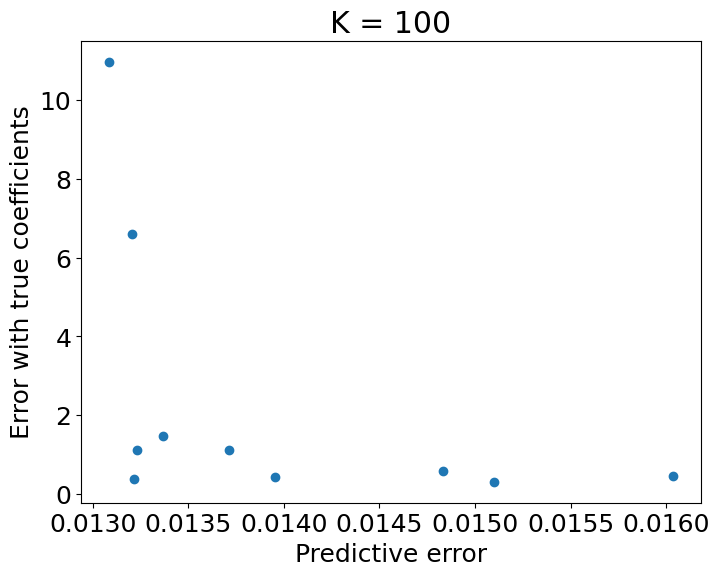

In [12]:
fig, ax = plt.subplots()
ax.plot(all_rmse_predictive, all_rmse_true, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Predictive error")
ax.set_ylabel("Error with true coefficients")

Now, we can look at a Pareto plot of the predictive errors against the number of terms, or complexities, of the models

Text(0, 0.5, 'Predictive error')

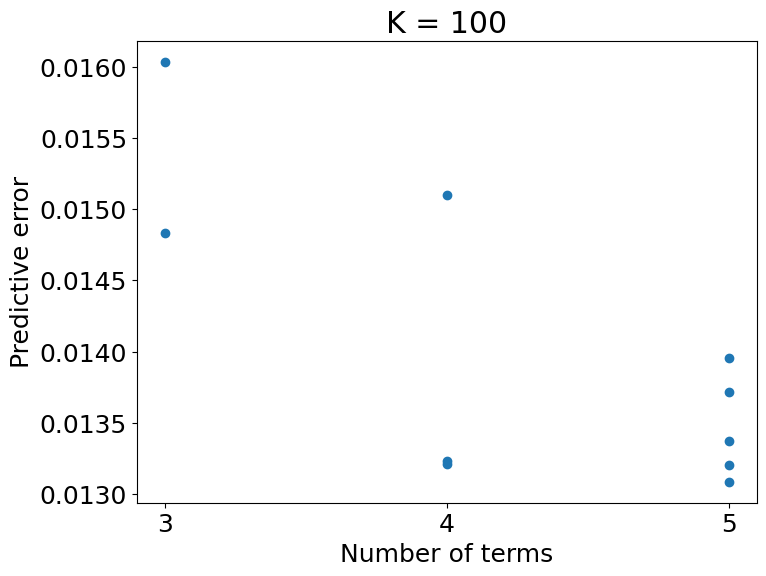

In [13]:
# calculate complexities, or number of terms, of all models
all_complexities = np.array([])
for model in all_models:
    complexity = np.count_nonzero(model.coefficients())
    all_complexities = np.hstack((all_complexities, complexity))

fig, ax = plt.subplots()
ax.plot(all_complexities, all_rmse_predictive, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Number of terms")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Predictive error")

## `K = 300`

In [14]:
# set K
K=300

# generate fitted "test model" SINDy instance to pass into the 
# 'kfold_training' function, this way it gets all the relevant 
# SINDy parameters
weak_library = ys.generate_weak_Yukawa_library(t_data,K=K)
optimizer = ps.STLSQ(threshold=threshold)
test_model = ps.SINDy(
    optimizer = optimizer,
    feature_library = weak_library
)
test_model.fit(x_train_list, t_data, multiple_trajectories=True)

# perform kfold cross-val
all_models, all_rmse_predictive = cv.kfold_training(
    x_train,
    t_data,
    10,
    test_model  
)

# collect coefficients
all_coefs = np.array([model.coefficients() for model in all_models])
all_rmse_true = np.array([])
for coefs in all_coefs:
    rmse_true = root_mean_squared_error(correct_coefs, coefs)
    all_rmse_true = np.hstack((all_rmse_true, rmse_true))

# print all models
for i, model in enumerate(all_models):
    print(f"Model {i}")
    model.print()
    print(f"pred rmse: {all_rmse_predictive[i]:.4f}")
    print(f"true rmse: {all_rmse_true[i]:.4f}")
    print(60*'-' + '\n')

Model 0
(x0)' = 1.000 x1
(x1)' = 4.967 exp(-x0) / x0 + 3.782 exp(-x0) / x0^2
pred rmse: 0.0144
true rmse: 0.0838
------------------------------------------------------------

Model 1
(x0)' = 1.000 x1
(x1)' = 4.494 exp(-x0) / x0 + 4.267 exp(-x0) / x0^2
pred rmse: 0.0136
true rmse: 0.0232
------------------------------------------------------------

Model 2
(x0)' = 0.998 x1
(x1)' = 5.773 exp(-x0) / x0 + 2.970 exp(-x0) / x0^2
pred rmse: 0.0151
true rmse: 0.1983
------------------------------------------------------------

Model 3
(x0)' = 0.998 x1
(x1)' = 4.521 exp(-x0) / x0 + 4.321 exp(-x0) / x0^2
pred rmse: 0.0140
true rmse: 0.0177
------------------------------------------------------------

Model 4
(x0)' = 1.000 x1
(x1)' = 5.541 exp(-x0) / x0 + 3.175 exp(-x0) / x0^2
pred rmse: 0.0143
true rmse: 0.1673
------------------------------------------------------------

Model 5
(x0)' = 0.999 x1
(x1)' = 5.558 exp(-x0) / x0 + 3.151 exp(-x0) / x0^2
pred rmse: 0.0142
true rmse: 0.1703
------------

In [15]:
print("Best prediction:")
print(f"Model {all_rmse_predictive.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive.min()}")
print(f"True coef rmse: {all_rmse_true[all_rmse_predictive.argmin()]}")
all_models[all_rmse_predictive.argmin()].print()
print(60*'-' + '\n')

print("Closest to true:")
print(f"Model {all_rmse_true.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive[all_rmse_true.argmin()]}")
print(f"True coef rmse: {all_rmse_true.min()}")
all_models[all_rmse_true.argmin()].print()

Best prediction:
Model 7
Predictive rmse: 0.013362450103689617
True coef rmse: 0.3450315022789842
(x0)' = 0.998 x1
(x1)' = 2.866 exp(-x0) / x0 + 6.916 exp(-x0) / x0^2 + 0.037 exp(-x0) / x0^3 + -0.791 exp(-x0) / x0^4
------------------------------------------------------------

Closest to true:
Model 3
Predictive rmse: 0.013988550219407488
True coef rmse: 0.01767270340500309
(x0)' = 0.998 x1
(x1)' = 4.521 exp(-x0) / x0 + 4.321 exp(-x0) / x0^2


Text(0, 0.5, 'Error with true coefficients')

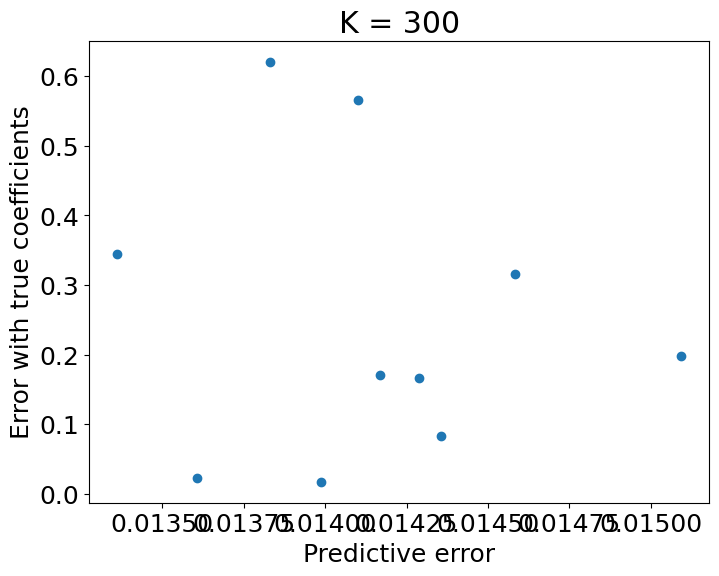

In [16]:
fig, ax = plt.subplots()
ax.plot(all_rmse_predictive, all_rmse_true, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Predictive error")
ax.set_ylabel("Error with true coefficients")

Text(0, 0.5, 'Predictive error')

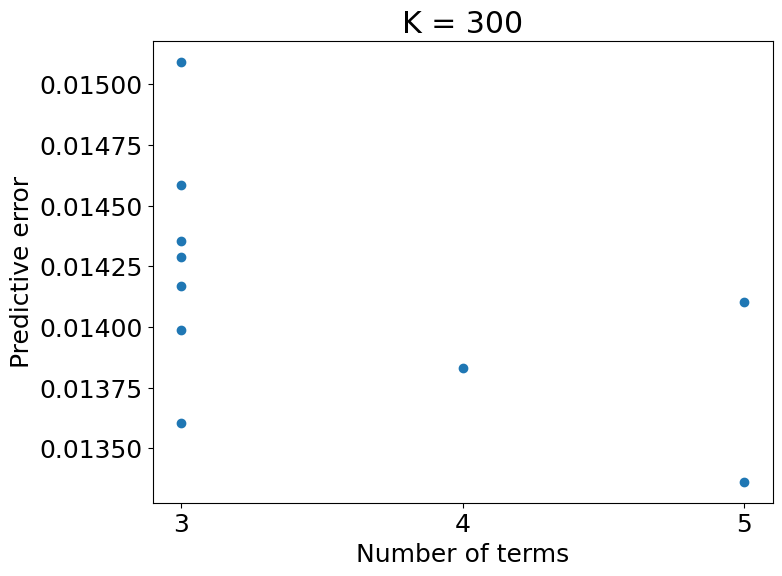

In [17]:
# calculate complexities, or number of terms, of all models
all_complexities = np.array([])
for model in all_models:
    complexity = np.count_nonzero(model.coefficients())
    all_complexities = np.hstack((all_complexities, complexity))

fig, ax = plt.subplots()
ax.plot(all_complexities, all_rmse_predictive, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Number of terms")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Predictive error")


## `K = 500`

In [18]:
# set K
K=500

# generate fitted "test model" SINDy instance to pass into the 
# 'kfold_training' function, this way it gets all the relevant 
# SINDy parameters
weak_library = ys.generate_weak_Yukawa_library(t_data,K=K)
optimizer = ps.STLSQ(threshold=threshold)
test_model = ps.SINDy(
    optimizer = optimizer,
    feature_library = weak_library
)
test_model.fit(x_train_list, t_data, multiple_trajectories=True)

# perform kfold cross-val
all_models, all_rmse_predictive = cv.kfold_training(
    x_train,
    t_data,
    10,
    test_model  
)

# collect coefficients
all_coefs = np.array([model.coefficients() for model in all_models])
all_rmse_true = np.array([])
for coefs in all_coefs:
    rmse_true = root_mean_squared_error(correct_coefs, coefs)
    all_rmse_true = np.hstack((all_rmse_true, rmse_true))

# print all models
for i, model in enumerate(all_models):
    print(f"Model {i}")
    model.print()
    print(f"pred rmse: {all_rmse_predictive[i]:.4f}")
    print(f"true rmse: {all_rmse_true[i]:.4f}")
    print(60*'-' + '\n')

Model 0
(x0)' = 0.999 x1
(x1)' = 4.501 exp(-x0) / x0 + 4.276 exp(-x0) / x0^2
pred rmse: 0.0141
true rmse: 0.0222
------------------------------------------------------------

Model 1
(x0)' = 0.999 x1
(x1)' = 4.335 exp(-x0) / x0 + 4.415 exp(-x0) / x0^2
pred rmse: 0.0139
true rmse: 0.0241
------------------------------------------------------------

Model 2
(x0)' = 1.000 x1
(x1)' = 1.691 exp(-x0) / x0 + 10.496 exp(-x0) / x0^2 + -3.264 exp(-x0) / x0^3 + 0.128 exp(-x0) / x0^4
pred rmse: 0.0139
true rmse: 0.8625
------------------------------------------------------------

Model 3
(x0)' = 0.999 x1
(x1)' = 6.457 exp(-x0) / x0 + 2.228 exp(-x0) / x0^2
pred rmse: 0.0145
true rmse: 0.2992
------------------------------------------------------------

Model 4
(x0)' = 0.998 x1
(x1)' = 6.168 exp(-x0) / x0 + 2.551 exp(-x0) / x0^2
pred rmse: 0.0147
true rmse: 0.2559
------------------------------------------------------------

Model 5
(x0)' = 1.000 x1
(x1)' = 4.228 exp(-x0) / x0 + 4.490 exp(-x0) / x0^

In [19]:
print("Best prediction:")
print(f"Model {all_rmse_predictive.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive.min()}")
print(f"True coef rmse: {all_rmse_true[all_rmse_predictive.argmin()]}")
all_models[all_rmse_predictive.argmin()].print()
print(60*'-' + '\n')

print("Closest to true:")
print(f"Model {all_rmse_true.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive[all_rmse_true.argmin()]}")
print(f"True coef rmse: {all_rmse_true.min()}")
all_models[all_rmse_true.argmin()].print()

Best prediction:
Model 5
Predictive rmse: 0.013743294409634663
True coef rmse: 0.02624799356783807
(x0)' = 1.000 x1
(x1)' = 4.228 exp(-x0) / x0 + 4.490 exp(-x0) / x0^2
------------------------------------------------------------

Closest to true:
Model 0
Predictive rmse: 0.01407021759098314
True coef rmse: 0.02220238223832933
(x0)' = 0.999 x1
(x1)' = 4.501 exp(-x0) / x0 + 4.276 exp(-x0) / x0^2


Text(0, 0.5, 'Error with true coefficients')

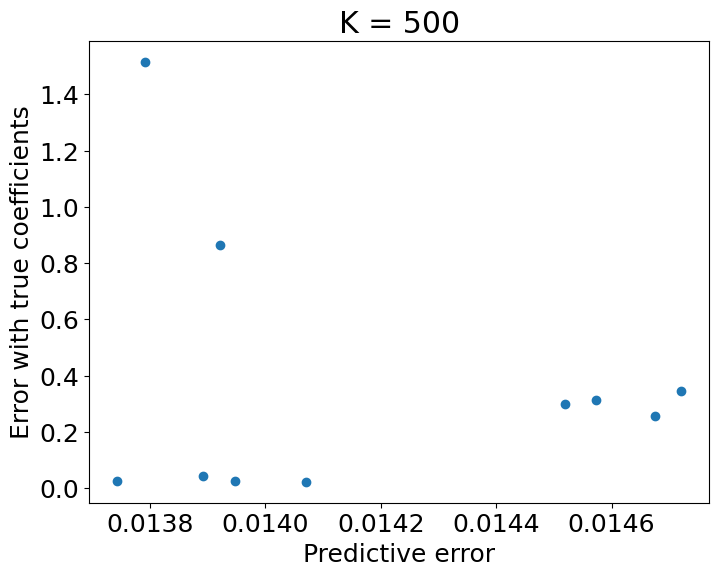

In [20]:
fig, ax = plt.subplots()
ax.plot(all_rmse_predictive, all_rmse_true, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Predictive error")
ax.set_ylabel("Error with true coefficients")

Text(0, 0.5, 'Predictive error')

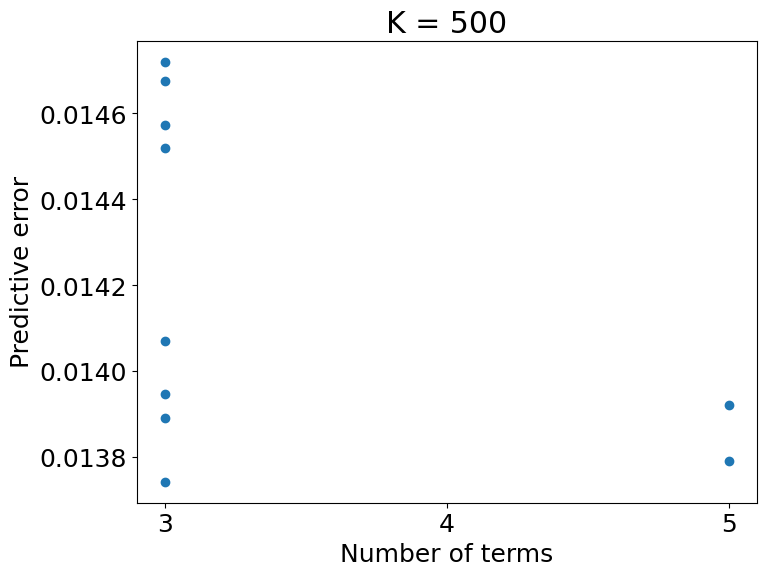

In [21]:
# calculate complexities, or number of terms, of all models
all_complexities = np.array([])
for model in all_models:
    complexity = np.count_nonzero(model.coefficients())
    all_complexities = np.hstack((all_complexities, complexity))

fig, ax = plt.subplots()
ax.plot(all_complexities, all_rmse_predictive, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Number of terms")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Predictive error")


## `K = 700`

In [22]:
# set K
K=700

# generate fitted "test model" SINDy instance to pass into the 
# 'kfold_training' function, this way it gets all the relevant 
# SINDy parameters
weak_library = ys.generate_weak_Yukawa_library(t_data,K=K)
optimizer = ps.STLSQ(threshold=threshold)
test_model = ps.SINDy(
    optimizer = optimizer,
    feature_library = weak_library
)
test_model.fit(x_train_list, t_data, multiple_trajectories=True)

# perform kfold cross-val
all_models, all_rmse_predictive = cv.kfold_training(
    x_train,
    t_data,
    10,
    test_model  
)

# collect coefficients
all_coefs = np.array([model.coefficients() for model in all_models])
all_rmse_true = np.array([])
for coefs in all_coefs:
    rmse_true = root_mean_squared_error(correct_coefs, coefs)
    all_rmse_true = np.hstack((all_rmse_true, rmse_true))

# print all models
for i, model in enumerate(all_models):
    print(f"Model {i}")
    model.print()
    print(f"pred rmse: {all_rmse_predictive[i]:.4f}")
    print(f"true rmse: {all_rmse_true[i]:.4f}")
    print(60*'-' + '\n')

Model 0
(x0)' = 1.000 x1
(x1)' = 5.987 exp(-x0) / x0 + 2.675 exp(-x0) / x0^2
pred rmse: 0.0158
true rmse: 0.2342
------------------------------------------------------------

Model 1
(x0)' = 0.999 x1
(x1)' = 5.119 exp(-x0) / x0 + 3.618 exp(-x0) / x0^2
pred rmse: 0.0220
true rmse: 0.1062
------------------------------------------------------------

Model 2
(x0)' = 0.998 x1
(x1)' = 2.234 exp(-x0) / x0 + 8.949 exp(-x0) / x0^2 + -2.252 exp(-x0) / x0^3 + 0.019 exp(-x0) / x0^4
pred rmse: 0.0136
true rmse: 0.6355
------------------------------------------------------------

Model 3
(x0)' = 0.999 x1
(x1)' = 5.529 exp(-x0) / x0 + 3.142 exp(-x0) / x0^2
pred rmse: 0.0139
true rmse: 0.1688
------------------------------------------------------------

Model 4
(x0)' = 0.999 x1
(x1)' = 5.330 exp(-x0) / x0 + 3.428 exp(-x0) / x0^2
pred rmse: 0.0144
true rmse: 0.1345
------------------------------------------------------------

Model 5
(x0)' = 1.000 x1 + -0.726 exp(-x0) / x0^2 + 0.567 exp(-x0) / x0^3
(x

In [23]:
print("Best prediction:")
print(f"Model {all_rmse_predictive.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive.min()}")
print(f"True coef rmse: {all_rmse_true[all_rmse_predictive.argmin()]}")
all_models[all_rmse_predictive.argmin()].print()
print(60*'-' + '\n')

print("Closest to true:")
print(f"Model {all_rmse_true.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive[all_rmse_true.argmin()]}")
print(f"True coef rmse: {all_rmse_true.min()}")
all_models[all_rmse_true.argmin()].print()

Best prediction:
Model 2
Predictive rmse: 0.013577217549564605
True coef rmse: 0.6355111842681317
(x0)' = 0.998 x1
(x1)' = 2.234 exp(-x0) / x0 + 8.949 exp(-x0) / x0^2 + -2.252 exp(-x0) / x0^3 + 0.019 exp(-x0) / x0^4
------------------------------------------------------------

Closest to true:
Model 8
Predictive rmse: 0.014102769214486706
True coef rmse: 0.02308130029060265
(x0)' = 0.999 x1
(x1)' = 4.484 exp(-x0) / x0 + 4.280 exp(-x0) / x0^2


Text(0, 0.5, 'Error with true coefficients')

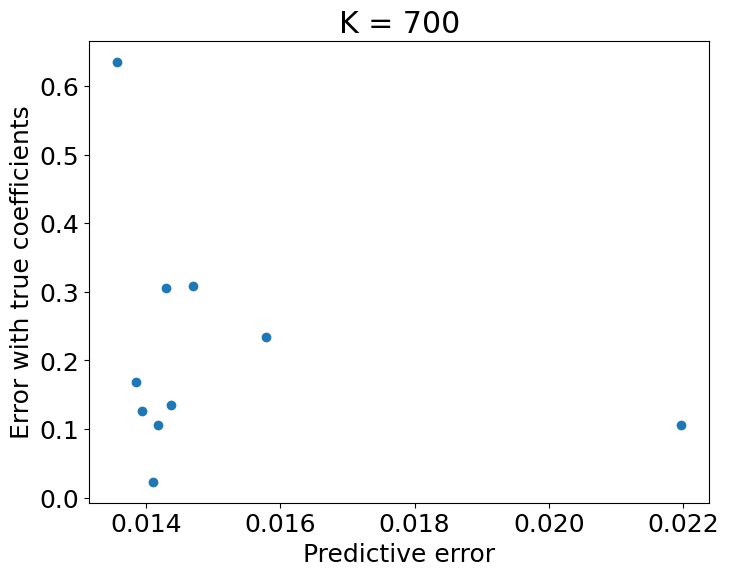

In [24]:
fig, ax = plt.subplots()
ax.plot(all_rmse_predictive, all_rmse_true, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Predictive error")
ax.set_ylabel("Error with true coefficients")

Text(0, 0.5, 'Predictive error')

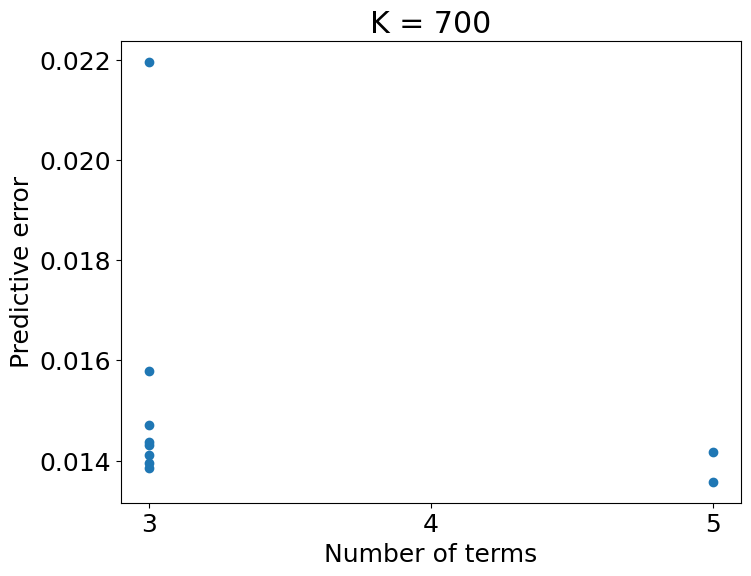

In [25]:
# calculate complexities, or number of terms, of all models
all_complexities = np.array([])
for model in all_models:
    complexity = np.count_nonzero(model.coefficients())
    all_complexities = np.hstack((all_complexities, complexity))

fig, ax = plt.subplots()
ax.plot(all_complexities, all_rmse_predictive, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Number of terms")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Predictive error")
